# Descriptive statistics for SULO

1. load each results/preprocessed/DATA\* file
2. Normalize the data
3. Compute total scores
4. Sort by factors
5. Plot heatmap

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import xlrd
import re

directory = os.fsencode('../results/preprocessed/')
# questdata_location = "https://docs.google.com/spreadsheets/d/1noblZmEJOm84o8Gca7ghre24VEqadK5ramcD25RMtic/export?format=xlsx"
questdata_location = 'questionnaire_and_answers.xlsx'
questdata = pd.read_excel(questdata_location)
perc=np.zeros((0,40));
scores=np.zeros((0,40));
backfact=np.zeros((0,6)); # site, age, sex, education, previously applied, previous app. in nursing
allskipped=np.zeros((0,1))
counter=0;

total_excluded=0
most_skipped=np.zeros(40)
for file in sorted(os.listdir(directory)):
    filename = os.fsdecode(file)
    if filename.endswith(".csv") & filename.startswith("DATA"): 
        # loading the file with NaNs as empty values
        # print(f"Processing {filename}")
        df = pd.read_csv('../results/preprocessed/'+filename, skip_blank_lines=False,header=None)
        data=np.genfromtxt('../results/preprocessed/'+filename,delimiter=';')
        
        bf_filename=filename.replace("DATA","BF")
        bdf = pd.read_csv('../results/preprocessed/'+bf_filename, sep=";", skip_blank_lines=False,header=None,dtype=object)

        # Non-working solution:
        # trueans=(data==1).astype(np.int); # ones are mapped to 1
        # falseans=-1*(data==2).astype(np.int); # twos are mapped to -1
        # ans=trueans+falseans # not enough 
        
        
        localscores=np.zeros((0,40))
        for i in range(data.shape[0]): # for each subject
            subjectdata=data[i]
            tempbackfact=bdf.iloc[i,[1, 2, 3, 4, 16]] # age, sex, edu, prev, prev_nursing 
            subjbackfact=np.zeros(5);
            for bfi in range(5):
                strval=tempbackfact.iloc[bfi]
                # get rid of spaces
                strval=strval.replace(" ","")
                # get rid of vuotias,vuotta,v
                strval=strval.replace("vuotias","")
                strval=strval.replace("vuotta","")
                strval=strval.replace("v","")
                # coding properly NaN
                if strval == "-1":
                    strval="0"
                # getting rid of weird stuff
                if strval == "--.--.----(--)": # age redacted
                    strval="21";
                if strval == "358":
                    strval="0"
                # other strange chars
                tempstr = strval.split('.');
                strval = tempstr[0];
                tempstr = strval.split('-');
                strval = tempstr[0];
                tempstr = strval.split('/');
                strval = tempstr[0];
                tempstr = strval.split(',');
                strval = tempstr[0];
                    
                # final QC
                isastring = re.search('[^\d]', strval)
                if isastring:
                    print("BF: "+str(bfi)+" "+strval)
                    print(isastring)
                else:
                    subjbackfact[bfi]=int(strval)
                    if subjbackfact[bfi] > 1930: # fixing those who put the year
                        subjbackfact[bfi]=2019-subjbackfact[bfi]
                    if subjbackfact[bfi]==0:
                        subjbackfact[bfi]=np.nan
                    if subjbackfact[0] < 18:
                        print("Not an adult?")
                        print(tempbackfact)
                    if subjbackfact[0] > 60:
                        print("Over 60?")
                        print(tempbackfact)
                    
                
            # process data
            score_temp=0*subjectdata
            skippedvec=np.zeros(40)
            for n in range(40):
                if((subjectdata[n]==1) & (questdata['Right'][n]==1)):
                    score_temp[n] = 1
                if((subjectdata[n]==1) & (questdata['Right'][n]==-1)):
                    score_temp[n] = -1
                if((subjectdata[n]==2) & (questdata['Right'][n]==1)):
                    score_temp[n] = -1
                if((subjectdata[n]==2) & (questdata['Right'][n]==-1)):
                    score_temp[n] = 1
                if(subjectdata[n]==3): # not sure
                    score_temp[n] = 0
                if(subjectdata[n]==- 1): # skipped items are computed later
                    score_temp[n] = np.nan
                    skippedvec[n] = 1
                                
            nskipped=np.sum(skippedvec)
            allskipped=np.vstack([allskipped, nskipped]);
            
            if nskipped > 0:
                # Uncomment below for interactive output
                #print("One subject skipped "+str(nskipped)+ "questions")
                most_skipped = most_skipped + skippedvec;
            
            if nskipped > round(40*.80): # we exclude this participant if more than 80 % of items were skipped
                total_excluded += 1
            else:
                # if we are here it is because it is a good subject
                temp = np.insert(subjbackfact, 0, counter)
                backfact=np.vstack([backfact, temp])
                BFfilenameout=filename.replace("DATA","BFVALS");
                np.savetxt('../results/scores/'+BFfilenameout,backfact,fmt="%2.0f", delimiter=',')
                scores=np.vstack([scores, score_temp]) # add to global scores
                localscores=np.vstack([localscores, score_temp]) # add to local scores for plot
                filenameout=filename.replace("DATA","SCORES");
                np.savetxt('../results/scores/'+filenameout,localscores, fmt="%2.0f",delimiter=',')
        perc=np.vstack([perc, np.sum(localscores,0)/data.shape[0]]);
        counter=counter+1;
        


In [2]:
scores[8,:] # testing: showing data with missing values

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan,  1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.])

In [3]:
scores[17,:] # testing: showing data with missing values

array([ 1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])

In [4]:
# Further processing

# fixing NaN
for n in range(40):
    temp=scores[:,n]
    tempMed=np.nanmedian(temp)
    temp[np.isnan(temp)]=tempMed
    

In [5]:
scores[8,:] # testing: showing data with missing values replaced with median

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.])

In [6]:
scores[17,:] # testing: showing data with missing values replaced with median

array([ 1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.])

In [7]:
# Further processing

    


# Dichotomizing scores
scoresD = scores.copy();
scoresD[np.where(scores == -1)] = 0;
# sort by subscales
scores_sorted = scores[:,questdata['SortedOrder'].astype(np.int)-1]
perc_sorted = perc[:,questdata['SortedOrder'].astype(np.int)-1]
scoresD_sorted = scoresD[:,questdata['SortedOrder'].astype(np.int)-1]
classID = questdata['ClassID']
classID_sorted = classID[questdata['SortedOrder'].astype(np.int)-1]



# summaries
print(f"Total subjects excluded: {total_excluded}")
print(f"Times each question was skipped: {most_skipped}")
unique, counts = np.unique(allskipped, return_counts=True)
print("-----------")
print("Number of Skipped items, Number of participants who skipped ")
for n in range(len(unique)):
    print(f"{unique[n]:.0f}, {counts[n]}")



Total subjects excluded: 6
Times each question was skipped: [ 9.  8. 10.  6. 10.  8. 10. 10. 10.  9.  7.  9.  9.  7.  9. 10. 15. 11.
 17. 12. 11. 13. 12. 14. 10. 14. 12. 14. 13. 11. 13. 12. 13. 15. 14. 16.
 15. 18. 16. 16.]
-----------
Number of Skipped items, Number of participants who skipped 
0, 1041
1, 43
2, 12
5, 10
6, 1
8, 1
10, 4
17, 1
20, 2
40, 6


In [8]:
agedistr=np.nanpercentile(backfact[:,1],[0, 25, 50, 75, 100])
agemedian=np.nanmedian(backfact[:,1])
agemean=np.nanmean(backfact[:,1])
allages=backfact[:,1]
allages = allages[np.logical_not(np.isnan(allages))]
agestd=np.std(allages)
agemean2=np.mean(allages)
print("Age distribution: min, 25th percentile, median, 75th percentile, max")
print(agedistr)
print("Age mean")
print(agemean)
print(agemean2)
print("Age std")
print(agestd)

preferenot=np.where(np.isnan(backfact[:,1]))[0].shape[0]
print("Num of subjects who did not want to disclose their age: "+str(preferenot))
numtotalBF=backfact.shape[0]
numtotalData=scores.shape[0]
if numtotalBF != numtotalData:
    print("Mismatch in number of subjects between data and BF")
males=np.where(backfact[:,2]==1)[0].shape[0]
females=np.where(backfact[:,2]==2)[0].shape[0]
preferenot=np.where(np.isnan(backfact[:,2]))[0].shape[0]
print("Distribution of sex. Total num of subjects: "+str(numtotalBF)+", M: "+str(males)+"("+str(round(males/numtotalBF*10000)/100)+"%), F: "+str(females)+"("+str(round(females/numtotalBF*10000)/100)+"%), n/a: "+str(preferenot)+"("+str(round(preferenot/numtotalBF*10000)/100)+"%)")



#bflabels=["Sex", "Education", "Previous app", "Previous app in nursing"]
#for i in range(4):
#    print("----")
#    print(bflabels[i])
#    temp = backfact[:,i+2]
#    temp[np.isnan(temp)] = -1
#    unique, counts = np.unique(temp, return_counts=True)
#    print(np.asarray((unique, counts)).T)


Age distribution: min, 25th percentile, median, 75th percentile, max
[18.  20.  21.5 27.  55. ]
Age mean
24.410649819494584
24.410649819494584
Age std
7.117892891630485
Num of subjects who did not want to disclose their age: 7
Distribution of sex. Total num of subjects: 1115, M: 155(13.9%), F: 954(85.56%), n/a: 6(0.54%)


In [9]:
# Printing the table for the manuscript as a CSV

print("Demographic information of participants (N = " + str(numtotalBF) + "(*))")

print("Variable, N, %, Range, Mean (SD)")
# Age
ageN = np.where(~np.isnan(backfact[:,1]))[0].shape[0];
ageNmissing = np.where(np.isnan(backfact[:,1]))[0].shape[0];
agemin = np.nanmin(backfact[:,1]) 
agemax = np.nanmax(backfact[:,1])
agemean = np.nanmean(backfact[:,1])
temp = backfact[:,1]
temp = temp[np.logical_not(np.isnan(temp))]
agestd = np.std(temp)
print(f"Age in years, {ageN}, , {agemin:.0f}—{agemax:.0f}, {agemean:.2f}({agestd:.2f})")

# Sex
sexNmissing = np.where(np.isnan(backfact[:,2]))[0].shape[0]
sexNm = np.where(backfact[:,2]==1)[0].shape[0]
sexNf = np.where(backfact[:,2]==2)[0].shape[0]
sexTot = sexNm + sexNf
sexNmperc = 100*sexNm/sexTot
sexNfperc = 100*sexNf/sexTot
print("Sex, , , , ")
print(f"   Female, {sexNf:.0f}, {sexNfperc:.1f}, , ")
print(f"   Male, {sexNm:.0f}, {sexNmperc:.1f}, , ")



# Background
bkgNmissing = np.where(np.isnan(backfact[:,3]))[0].shape[0]
bkgNhs = np.where(backfact[:,3]==1)[0].shape[0]
bkgNvs = np.where(backfact[:,3]==2)[0].shape[0]
bkgTot = bkgNhs + bkgNvs
bkgNhsperc = 100*bkgNhs/bkgTot
bkgNvsperc = 100*bkgNvs/bkgTot
print("Background education, , , , ")
print(f"   High school, {bkgNhs:.0f}, {bkgNhsperc:.1f}, , ")
print(f"   Vocational school, {bkgNvs:.0f}, {bkgNvsperc:.1f}, , ")


# Prev degree
prevNmissing = np.where(np.isnan(backfact[:,4]))[0].shape[0]
prevNy = np.where(backfact[:,4]==1)[0].shape[0]
prevNn = np.where(backfact[:,4]==2)[0].shape[0]
prevTot = prevNy + prevNn
prevNyperc = 100*prevNy/prevTot
prevNnperc = 100*prevNn/prevTot
print("Previous degree in higher education, , , , ")
print(f"   Yes, {prevNy:.0f}, {prevNyperc:.1f}, , ")
print(f"   No, {prevNn:.0f}, {prevNnperc:.1f}, , ")


# Prev application in nursing
prevappNmissing = np.where(np.isnan(backfact[:,5]))[0].shape[0]
prevappNy = np.where(backfact[:,5]==1)[0].shape[0]
prevappNn = np.where(backfact[:,5]==2)[0].shape[0]
prevappTot = prevappNy + prevappNn
prevappNyperc = 100*prevappNy/prevappTot
prevappNnperc = 100*prevappNn/prevappTot
print("Previous applications for nursing education, , , , ")
print(f"   Yes, {prevappNy:.0f}, {prevappNyperc:.1f}, , ")
print(f"   No, {prevappNn:.0f}, {prevappNnperc:.1f}, , ")


# Missing values
print(" , , , , ")
print(f"(*) Missing values: Age in years (N = {ageNmissing}), gender (N = {sexNmissing}), background education (N = {bkgNmissing}), previous degree in higher education (N = {prevNmissing}), previous applications for nursing education (N = {prevappNmissing}).")


Demographic information of participants (N = 1115(*))
Variable, N, %, Range, Mean (SD)
Age in years, 1108, , 18—55, 24.41(7.12)
Sex, , , , 
   Female, 954, 86.0, , 
   Male, 155, 14.0, , 
Background education, , , , 
   High school, 596, 53.7, , 
   Vocational school, 514, 46.3, , 
Previous degree in higher education, , , , 
   Yes, 97, 8.8, , 
   No, 1007, 91.2, , 
Previous applications for nursing education, , , , 
   Yes, 452, 40.8, , 
   No, 655, 59.2, , 
 , , , , 
(*) Missing values: Age in years (N = 7), gender (N = 6), background education (N = 5), previous degree in higher education (N = 11), previous applications for nursing education (N = 8).


## Storing the output

Saving the results in "results/scores", and after that we continue with R.

In [10]:
# storing the output
headerout = []
headerout_sorted = []
for i in range(40):
    headerout.append('C'+str(classID[i])+'_Q'+str(i+1))

for i in range(40):    
    headerout_sorted.append(headerout[questdata['SortedOrder'][i]-1])

headerout_sorted
np.savetxt('../results/scores/scores.csv', scores, delimiter=',',header=', '.join(headerout), comments='')
np.savetxt('../results/scores/scores_sorted.csv', scores_sorted,fmt="%2.0f", delimiter=',',header=', '.join(headerout_sorted), comments='')
np.savetxt('../results/scores/scoresD.csv', scoresD, delimiter=',',header=', '.join(headerout), comments='')
np.savetxt('../results/scores/scoresD_sorted.csv', scoresD_sorted,fmt="%2.0f", delimiter=',',header=', '.join(headerout_sorted), comments='')


BFheader = ['Site','Age','Sex','Background','Previous education','Previous application']
np.savetxt('../results/scores/background.csv', backfact, fmt="%2.0f", delimiter=',',header=', '.join(BFheader), comments='')

# Let's do some plotting

<AxesSubplot:>

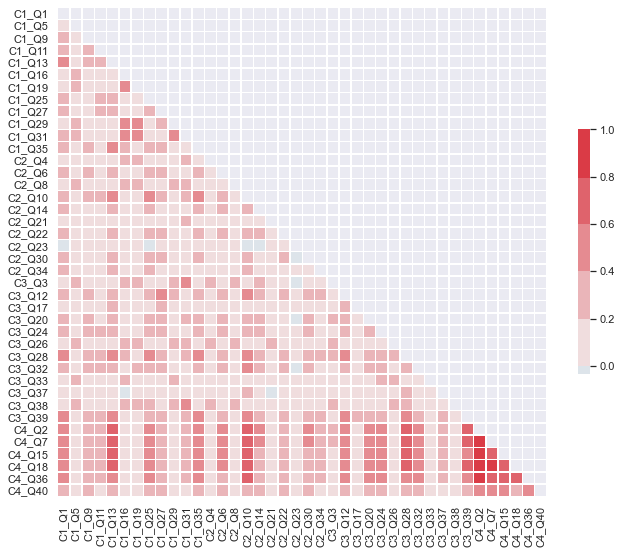

In [11]:
# Items to items plot

A=np.corrcoef(np.matrix.transpose(scoresD_sorted))
mask = np.triu(np.ones_like(A, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n = 10)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(A, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=headerout_sorted, yticklabels=headerout_sorted )

# end